In [0]:
#https://www.youtube.com/watch?v=SEnXr6v2ifU&list=PLtBw6njQRU-rwp5__7C0oIVt26ZgjG9NI&index=2
#http://introtodeeplearning.com/slides/6S191_MIT_DeepLearning_L2.pdf

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
import numpy as np

from keras.layers import Dense, Activation

TensorFlow 2.x selected.


Using TensorFlow backend.


#Lecture 2, Deep Sequence Modeling

##Text predictions

* Basically it is saying that an issue with text prediction models is that phrases and context have different sizes, how do you feed that to a network?
  * Idea #1 - Use a fixed window. Allways feed X number of words of characters to the network. The issue if that information is taken out (unless its really big window)

  * Idea #2 - Use entire sequence as a Set of Counts. The issue is that with counts, only the words are taken, not their order

  * Idea #3 - Use a really big fixed window. The issue is that the network might memorize certain orders and placements of words and it cannot generalized (No parameter sharing).

## Sequence Modeling: Design Criteria

We need to design models that:
1. Handle variable-length sequences

2. Track long-term dependencies.

3. Mantain information about order

4. Share parameters across the sequence

Today to solve this we use RNN's

#RNN's

###RNN's are well suited for handling cases where you have sequences of inputs rather than a single input.

They are great for problems where a sequence of data is being propagated to give a single output.  (Eg. Sequence of words and return a sentiment).

This networks also can return an output at each timestep in the sequence. (EG. Text or Music generation)

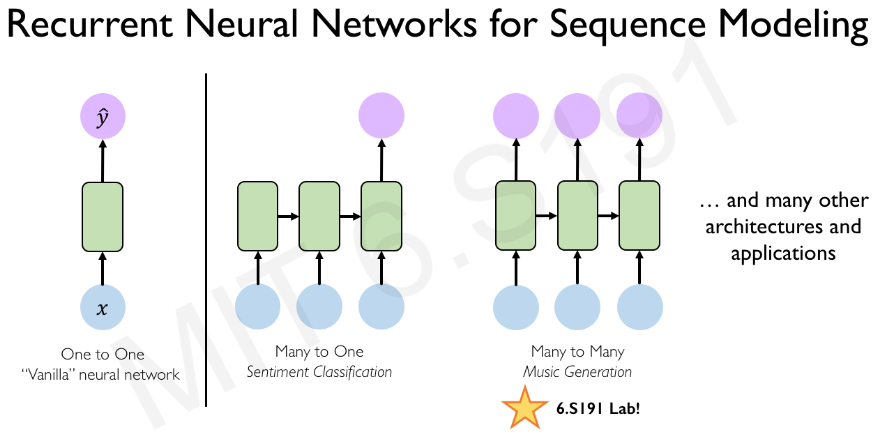

###Standard NNet vs Recurrent.

Recurrent Neural Networks have loops in them, which allow information to persist over time.

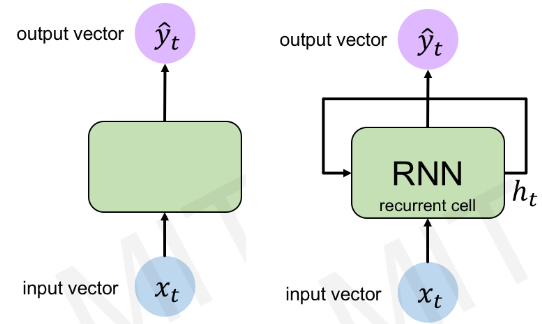

###"Under the hood" How is information passed timestep to timestep.

You use a simple recurrence relation at every time step to process a sequence

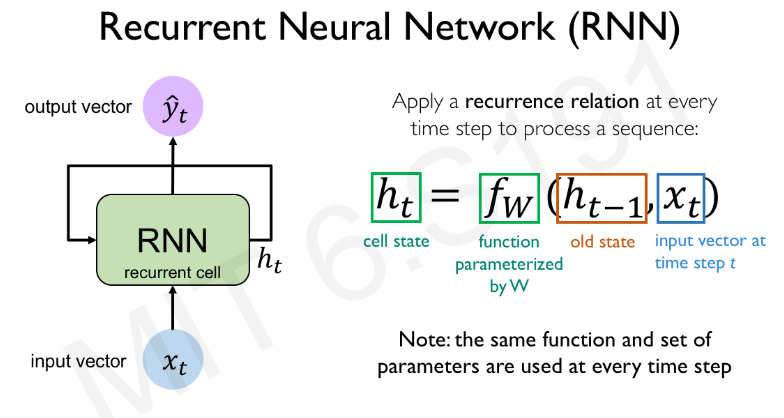

###RNN Pseudocode

####Initialize RNN

In [0]:
my_rnn = RNN()
hidden_state = [0,0,0,0]

sentence = ["I", "love", "recurrent", "neural"] #Sentence to predict next word

####Looping computation

In [0]:
for word in sentence:
  prediction, hidden_state = my_rnn(word, hidden_state)
  #We feed the current word (input), 
  #and the hidden_state, which is the "memory" of the network

####Get prediction


In [0]:
#This is the RNN prediction after all the words have been fed through the model.
next_word_prediction = prediction

#RNN State Update and Output

###How do the computations occur?

This is "simple":
1. Given our input vector xt

2. Update the hidden state using an standard NNET operation (tanh(WT....)). This basically multiplies a weight matrix and applies a non-linearity. but here since we have two inputs (prev state, current input), we sum them and then apply the non-linearity. 

3. Get an output vector. This is another multiplication of another weight matrix.

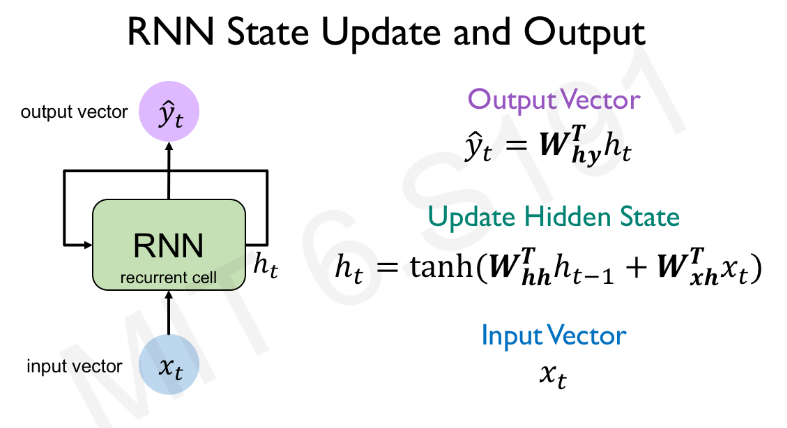

We can think of RNNs as having multiple copies of the same network, where each passes a message to its descendant. The message passed is based on the Internal state.

It is important to note that we use the same weights at every time-step, from this outputs, we can compute a Loss at each time-step. This computation of the loss will complete our forward propagation of the network. 
NOTE: We sum the loss of each step to get the loss of the network.




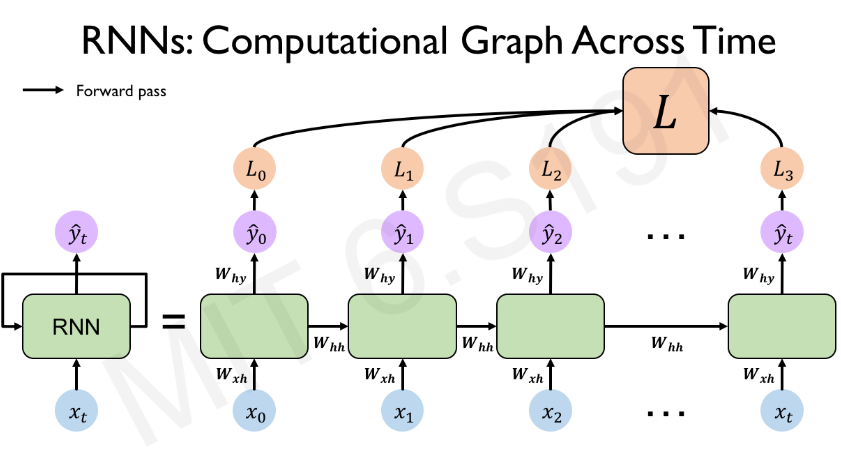

##Simple RNN from Scratch

In [0]:
class MyRNNCell(tf.keras.layers.Layer):
  def __init__(self, rnn_units, input_dim, output_dim):
    super(MyRNNCell, self).__init__()

    #initializing the weight matrices:
    self.W_xh = self.add_weight([rnn_units, input_dim])
    self.W_hh = self.add_weight([rnn_units, input_dim])
    self.W_xy = self.add_weight([rnn_units, input_dim])

    self.h = tf.zeros([rnn_units,1]) # the hidden state.

    def call(self,x): #describes how we make the forward pass throught the network (given an input X)
      #update the hidden state
      self.h = tf.math.tanh(self.W_hh * self.h * self.W_xh * x)

      #Compute the output
      output = self.W_hy * self.h

      return output, self.h




###Tensorflow already has a RNN build it.

```
tf.keras.layers.SimpleRNN(rnn_units)
```



#To train RNN's we use Backpropagation through time

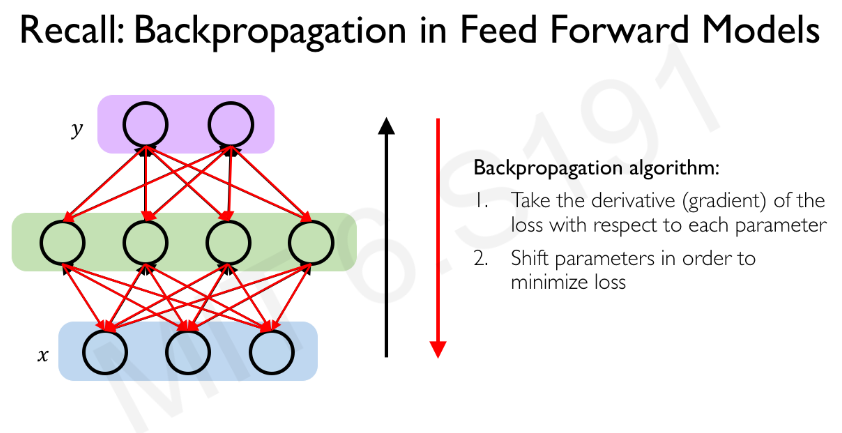

##In RNN's we have to do it differently
This is because our forward pass throught the network, also consists of going forward through time, updating the cell state depending on the loss of various time-steps.

This means that instead of backpropagating errors through a single network at a single time-step, we backpropagate errors at each individual time-step across all time-steps.



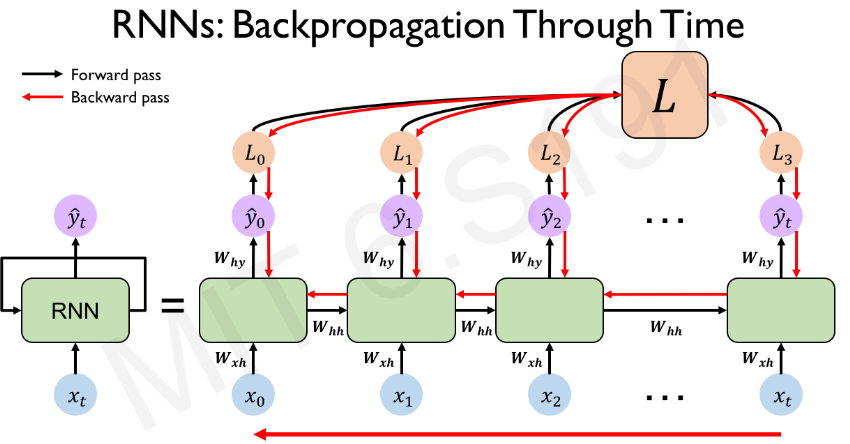

If we take a closer look at how gradients flow, we see that between each time-frame we need to do many repeated multiplications involving the weight matrix, as well as repeated use of the derivative of the activation function. Which can be problematic.

The following scenarios can be particularly problematic:
* Exploding gradients: We have many values that are large (>1), this describes when gradients just become too large and cant be optimized. - To solve this we can perform *Gradient clipping* which is basically scaling back gradients so that their values are smaller.

* Vanishing gradients: We have very small gradients, (<1), and we can no longer train the network. (Remember the graph from prev lecture, too small gradients will just never advance or get stuck in local minima.) - To solve this, we can use *modifying activation functions (choosing them properly)*, *Initialize weights creverly*, *Designing our network properly*

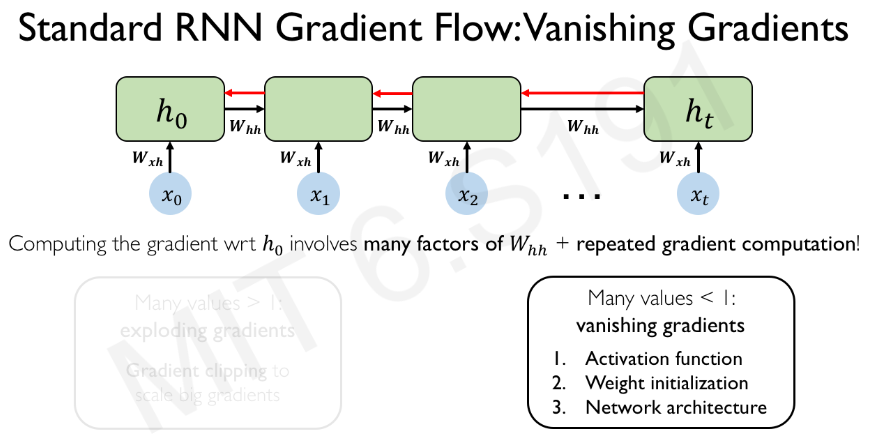

###Explaining vanishing gradients.

For example:
If you keep multipling a number by some number between 0 and 1. As you keep doing this, the number will keep shrinking and shrinking and eventually it will vanish (Become super small).

For gradients this means that you will not be able to backpropagate errors further to the past. -> which causes bias in the network to capture short-term properties

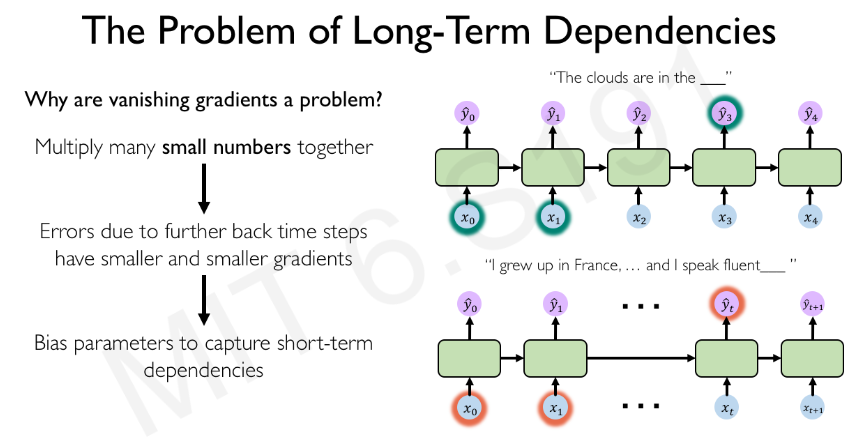

###How to aliviate this gradient problems

1. Change the activation function, use, Things like ReLU, Tanh.

2. Initialize parameters properly. Eg, initialize wieghts to identity matrix

3. The most robust solution is to use Gated Cells. 
  * This is a more complex recurrent unit with gates to control what information is passed through. (LSTM, GRU)


###We will focus on LSTMs


To understand LSTM's we go back to standard RNN's, In an standard RNN, repeating module contain a simple computation node:

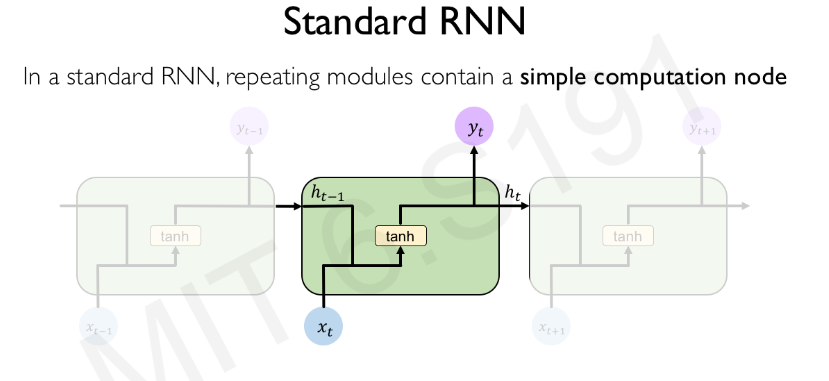


But LSTM's have much more complex computations. There is a more complex repating modules.

This layers selectively control information that goes thorugh the cell. 

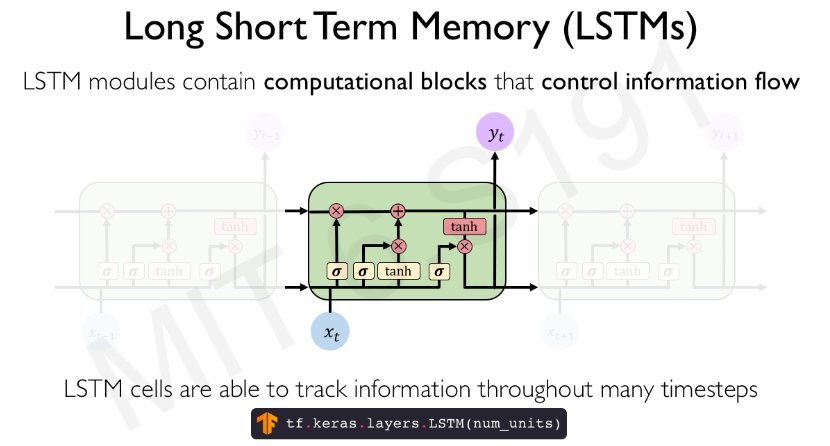

The key building block behind the LSTM is the gate:

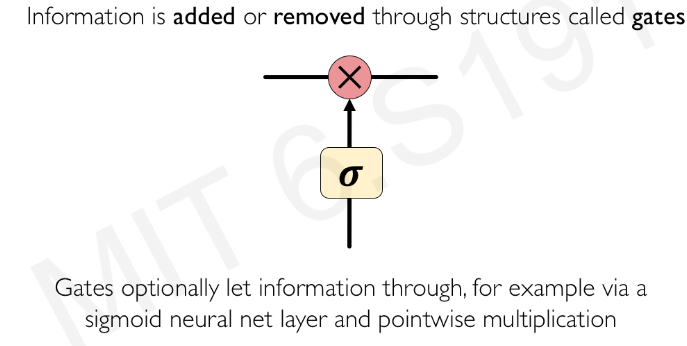

This structure consist of a NNet layer (sigmoid) and a point-wise multiplication.

In the image the sigmoid function is forcing the input to be something between 0 and 1. This could be translated into capturing how much the information passing through the gate should be retained.

###LSTMs process information through 4 steps.

1. Forget the irrelevant history (xt, ht-1 -> sigmoid -> ft(X))

2. Perform computations to store relevant parts of new information. (xt, ht-1 -> simgoid and tanh ->it(X)(+)

3. Update the internal state using the previous two steps, takes the relevant parts of the prior information as well as the current information and selectively updates its state. (ct-1 -> (X) -> (+) -> ct)

4. Generate an output (ht-1, xt -> sigmoid -> (tanh, x) -> ht) 

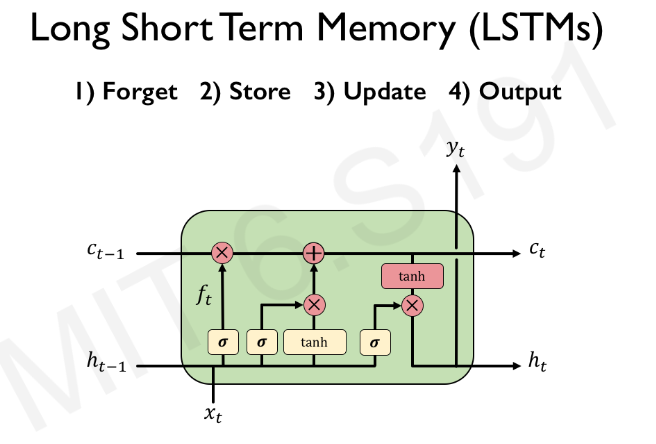

#####In the end all of this mechanisms work to create an internal self-state (c) to allow for the uninterrupted flow of gradients through time.

Its a "highway of cell states"

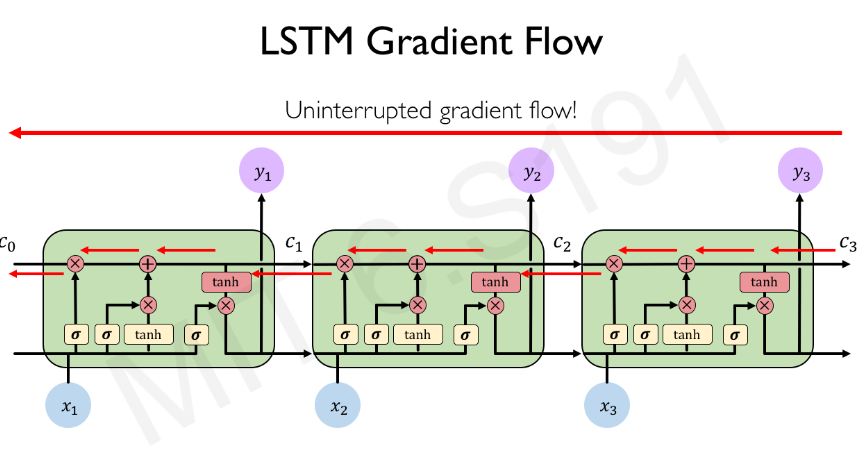

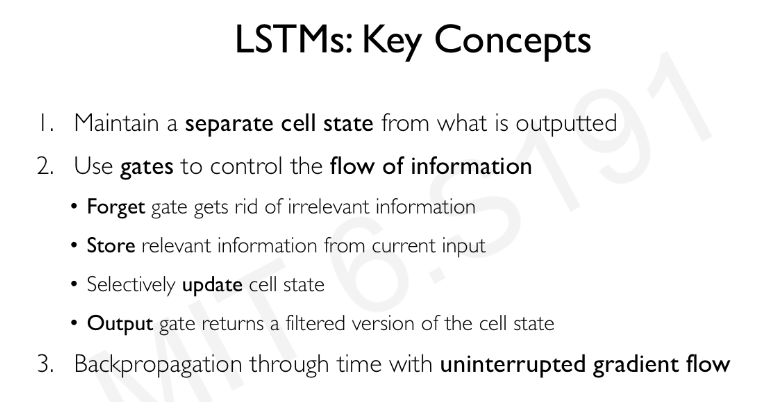

#RNN Applications

##Example Task: Music generation

* Input: sheet music

* output: next character in sheet music

##Example Task: Sentiment classification.

* Input: sequence of words
* Output: Probability of having a positive sentiment.

loss = tf.nn.softmax_cross_entropy_with_logits(y, predicted)





##Example Task: Machine Translation

* Input: sequence of words
* Output: sequence of words in another language

This mechanism has a strong bottleneck when it encodes the text and only gives the final state to the decoder.

This was "solved" by a mechanic called attention mechanism because it inputs parts of all the sentence.







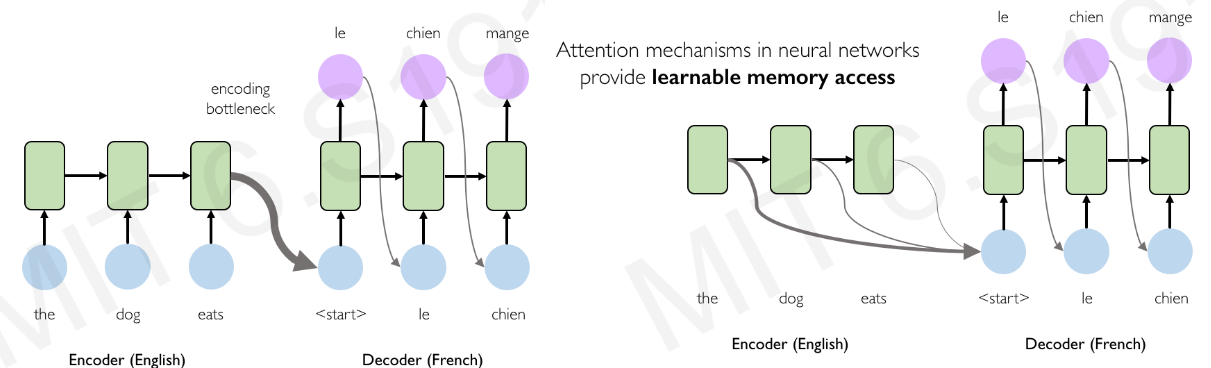